# Classifying individuals with chronic kidney disease based on age, blood urea level, and serum creatinine level

#### Aahil Tejani, Emily Xie, Emily Yip, Sarah Chan

## Introduction

Chronic kidney disease (CKD) occurs when the kidneys have been damaged over time and are unable to perform their functions. These functions include maintaining blood pressure, removing waste products, making red blood cells, and keeping the body balanced (National Kidney Foundation, 2024). This increases the risk of heart disease and stroke. Common symptoms include nausea, fatigue, urinating issues, decreased brain activity, and high blood pressure (National Kidney Foundation, 2024). However, symptoms resemble common illnesses, complicating early diagnosis without medical attention.

Those over the age of 60 years are at higher risk of CKD, as well as those with higher blood urea levels due to increased toxins from kidney failure (Laville et al., 2022). Elevated levels of serum creatinine, a waste product removed by kidneys, may also be an indicator of kidney failure (National Kidney Foundation, 2024). Hence, we propose to use these risk factors to classify patients if they have CKD.

In summary, the goal of this project is to use the risk factors such as age, level of blood urea and serum creatinine to classify patients based on their likeliness of having chronic kidney disease. Therefore, we will be addressing the question: **Is a new patient likely to have chronic kidney diseases based on age, blood urea level, and serum creatinine level?**

To achieve this, we will create a model using the data set Chronic Kidney Disease from UC Irvine Machine Learning Repository. The data was collected during a two month period in India with 25 variables. The dataset has 25 columns with one of them being the Class (**ckd**). 


## Preliminary Exploratory Data Analysis

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#set seed
set.seed(1)

#Read file from github and turn into csv
url = "https://raw.githubusercontent.com/schan26/dsci-100-grp18/main/chronic_kidney_disease_full.arff"
download.file(url, "ckd_data.csv")
ckd_data <- read_delim("ckd_data.csv", delim = ",", col_names = FALSE, skip = 145)

#add column names
colnames(ckd_data) <- c("age", "blood_pressure", "specific_gravity", 
                                    "albumin", "sugar", "red_blood_cells", "pus_cell", 
                                    "pus_cell_clumps", "bacteria", "blood_glucose_random", 
                                    "blood_urea", "serum_creatinine", "sodium", "potassium", 
                                    "hemoglobin", "packed_cell_volume", "white_blood_cell_count", 
                                    "red_blood_cell_count", "hypertension", "diabetes_mellitus", 
                                    "coronary_artery_disease", "appetite", "pedal_edema", 
                                    "anemia", "ckd")
#wrangling data
ckd_data[ckd_data == "?"] <- NA
ckd_data[ckd_data == "ckd" | ckd_data == "ckd," | ckd_data == "ckd\t"] <- "yes" #rename data to make it more readable
ckd_data[ckd_data == "no,notckd" | ckd_data == "notckd"] <- "no"

#Change to correct type
ckd_data[,c(1:5,10:18)] <- sapply(ckd_data[, c(1:5,10:18)], as.numeric )
ckd_data[,c(6:9,19:25)] <- lapply(ckd_data[, c(6:9,19:25)], as.factor )

#Selecting our predictors and varaiable only
ckd_analysis <- ckd_data |>
    select(ckd, age, blood_urea, serum_creatinine) |>
    na.omit()

#splitting data into training and testing datasets
ckd_data_split <- initial_split(ckd_analysis, prop = 0.75, strata = ckd)

ckd_training <- training(ckd_data_split)
ckd_testing <- testing(ckd_data_split)

glimpse(ckd_training)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 400 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”


Rows: 278
Columns: 4
$ ckd              <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ age              <dbl> 40, 23, 34, 60, 35, 49, 55, 45, 42, 55, 48, 25, 23, 3…
$ blood_urea       <dbl> 10, 36, 27, 10, 31, 32, 18, 46, 24, 17, 33, 19, 34, 2…
$ serum_creatinine <dbl> 1.2, 1.0, 1.2, 0.5, 1.2, 1.2, 0.9, 1.2, 0.7, 1.2, 0.9…


In [3]:
#exploratory data analysis: summarizing the min, max, mean of each predictor +
#                           total num of rows in each class
ckd_analysis <- ckd_training |>
    group_by(ckd) |>
    summarize(count = n(), 
              min_age = min(age, na.rm = TRUE), max_age = max(age, na.rm = TRUE), mean_age = mean(age, na.rm = TRUE),
              min_sc = min(serum_creatinine, na.rm = TRUE), max_sc = max(serum_creatinine, na.rm = TRUE), mean_sc = mean(serum_creatinine, na.rm = TRUE),
              min_bu = min(blood_urea, na.rm = TRUE), max_bu = max(blood_urea, na.rm = TRUE), mean_bu = mean(blood_urea, na.rm = TRUE))

#Number of missing values in each predictor
ckd_NA <- ckd_training |>
    group_by(ckd) |>
    select(ckd, age, blood_urea, serum_creatinine) |>
    summarise(across(,  ~sum(is.na(.)))) |>
    pivot_longer(cols = -ckd, names_to = "column", values_to = "count_na")

ckd_analysis
ckd_NA

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(, ~sum(is.na(.)))`.
Caused by warning:
! Using `across()` without supplying `.cols` was deprecated in dplyr 1.1.0.
ℹ Please supply `.cols` instead.”


ckd,count,min_age,max_age,mean_age,min_sc,max_sc,mean_sc,min_bu,max_bu,mean_bu
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,107,12,80,45.16822,0.4,1.2,0.8672897,10.0,50,31.01869
yes,171,3,90,55.51462,0.6,48.1,3.8745614,1.5,322,69.16491


ckd,column,count_na
<fct>,<chr>,<int>
no,age,0
no,blood_urea,0
no,serum_creatinine,0
yes,age,0
yes,blood_urea,0
yes,serum_creatinine,0


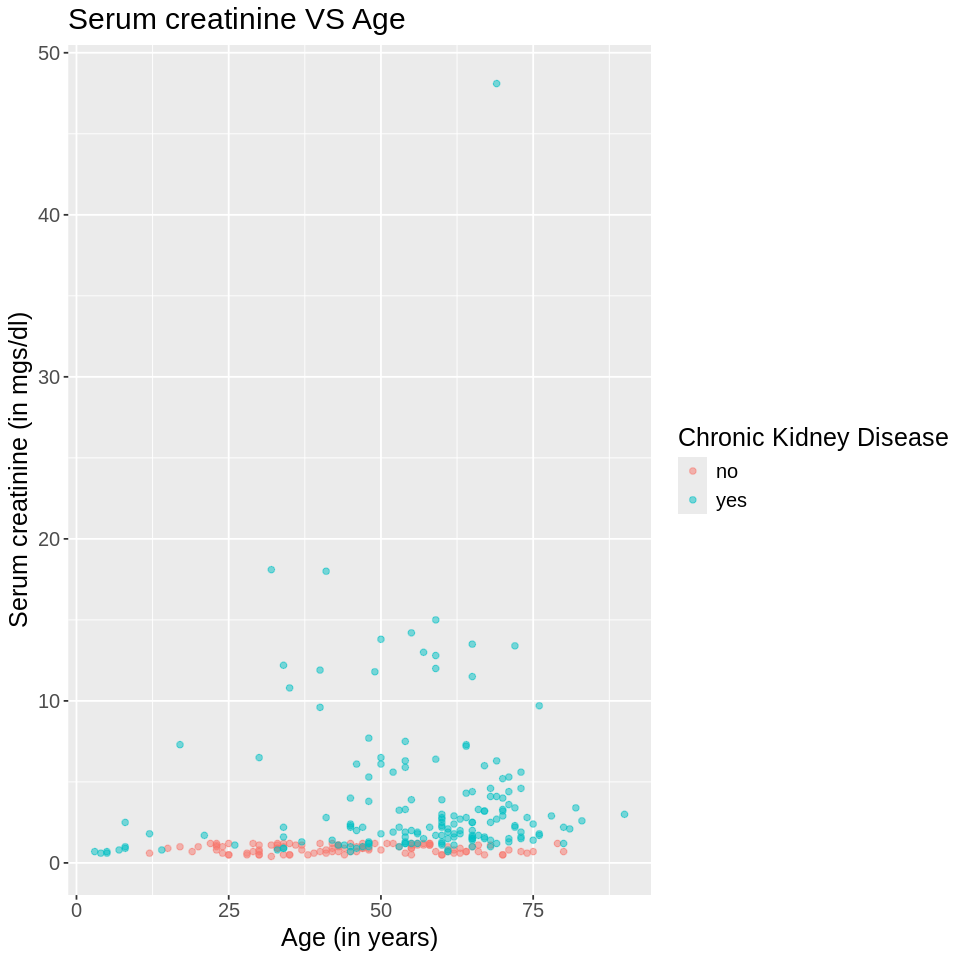

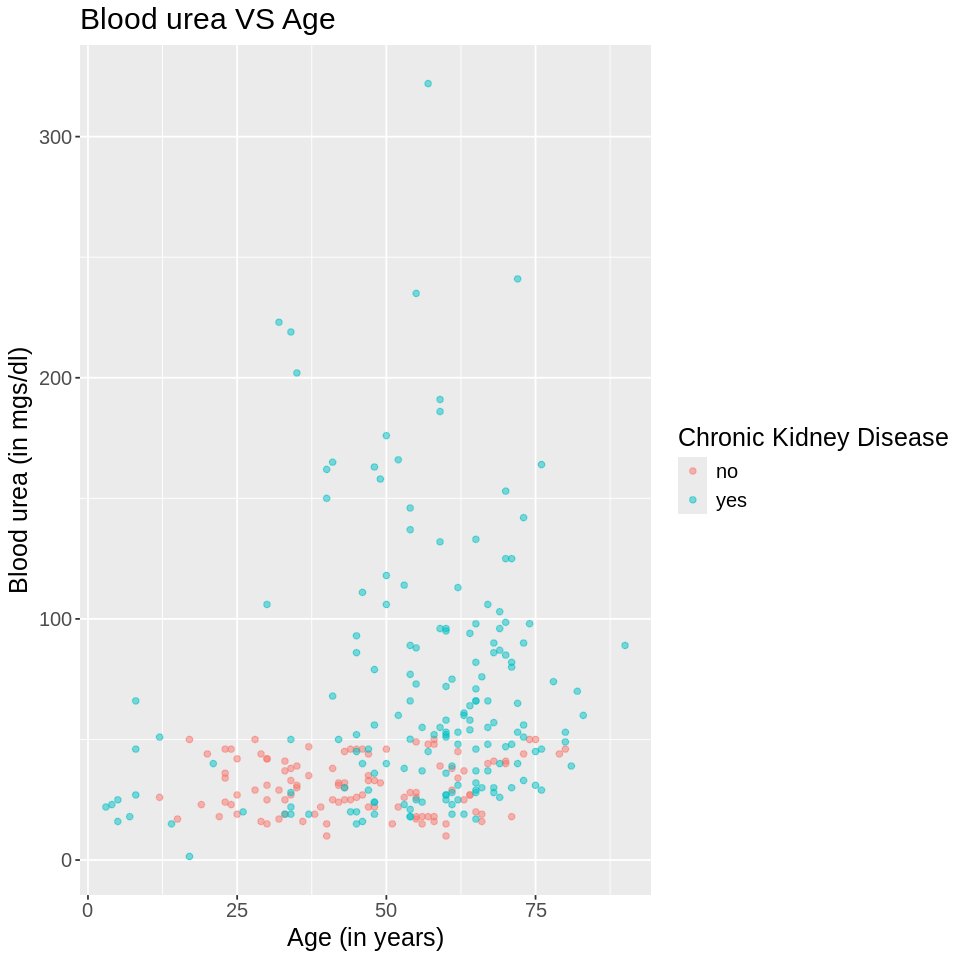

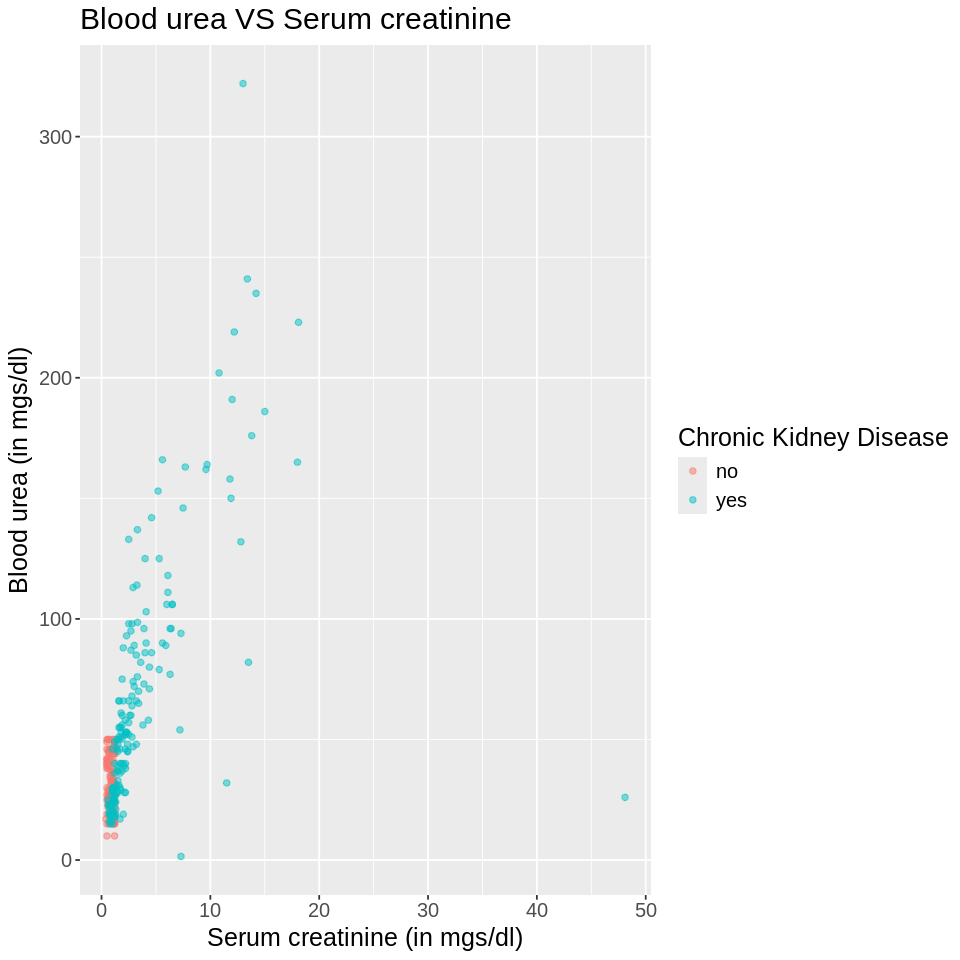

In [4]:
#plotting training data 
options(repr.plot.width = 8, repr.plot.height = 8) 
plot1 <- ggplot(ckd_training, aes(x = age, y = serum_creatinine, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (in years)", y = "Serum creatinine (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Serum creatinine VS Age") +
    theme(text=element_text(size=15))

plot2 <- ggplot(ckd_training, aes(x = age, y = blood_urea, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (in years)", y = "Blood urea (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Blood urea VS Age") +
    theme(text=element_text(size=15))

plot3 <- ggplot(ckd_training, aes(x = serum_creatinine, y = blood_urea, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Serum creatinine (in mgs/dl)", y = "Blood urea (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Blood urea VS Serum creatinine") +
    theme(text=element_text(size=15))

plot1
plot2
plot3

## Data Analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8558977,5,0.01988220,Preprocessor1_Model01
1,roc_auc,binary,0.8529514,5,0.01840242,Preprocessor1_Model01
2,accuracy,binary,0.8631704,5,0.01942065,Preprocessor1_Model02
2,roc_auc,binary,0.8929845,5,0.02322757,Preprocessor1_Model02
3,accuracy,binary,0.8488175,5,0.02463681,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,roc_auc,binary,0.8578075,5,0.02243606,Preprocessor1_Model23
24,accuracy,binary,0.7478366,5,0.03541817,Preprocessor1_Model24
24,roc_auc,binary,0.8542590,5,0.02038930,Preprocessor1_Model24


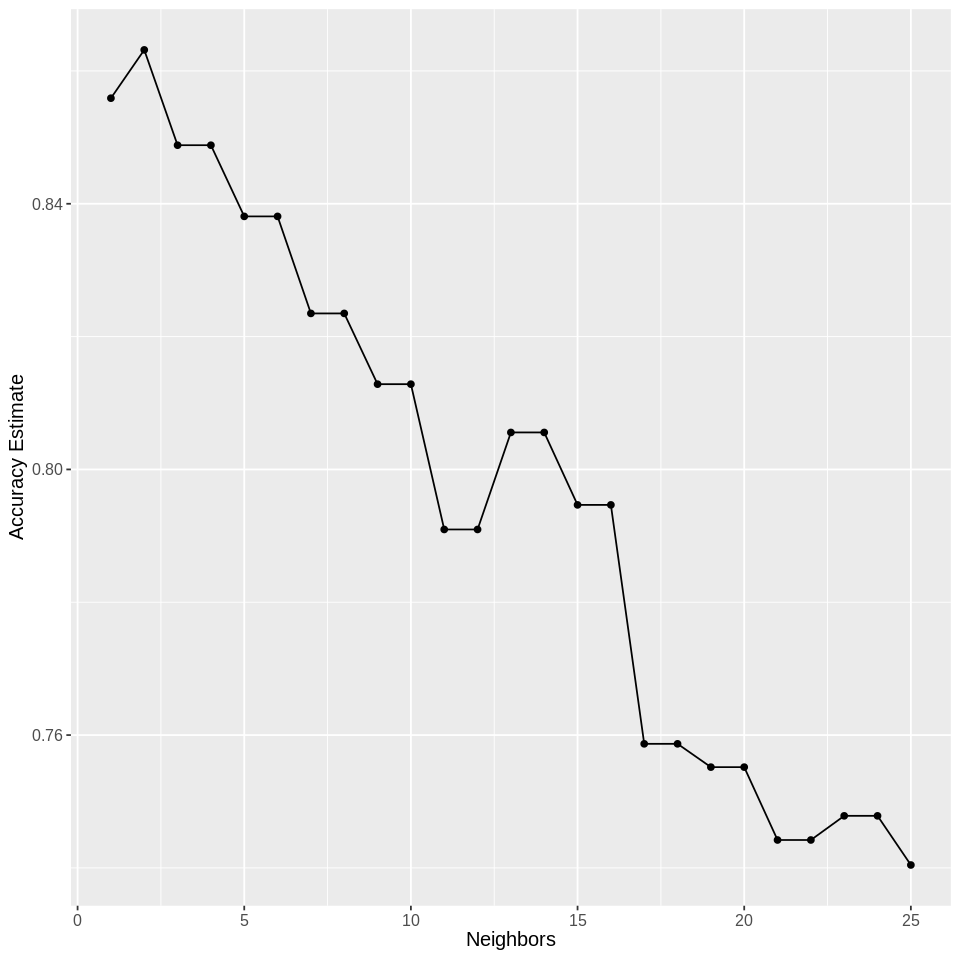

In [12]:
#knn-classification using tidymodels
set.seed(2)
options(repr.matrix.max.rows = 10)

ckd_recipe <- recipe(ckd ~ age + serum_creatinine + blood_urea, data = ckd_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

ckd_vfold <- vfold_cv(ckd_training, v=5, strata=ckd) 

gridvals <- tibble(neighbors = seq(from = 1, to=25, by=1))

ckd_fit <- workflow() |>
    add_recipe(ckd_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = ckd_vfold, grid = gridvals) |>
    collect_metrics()
ckd_fit

accuracies <- ckd_fit |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))
cross_val_plot

We choose k=2 based on this plot !!!

## Testing Our Model

In [8]:
# Final model
set.seed(9999)

knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

ckd_final_fit <- workflow() |>
    add_recipe(ckd_recipe) |>
    add_model(knn_final) |>
    fit(data = ckd_training)

In [11]:
#Predicting in testing dataset
ckd_predictions <- predict(ckd_final_fit, ckd_testing) |>
    bind_cols(ckd_testing)

ckd_metrics <- ckd_predictions |>
    metrics(truth = ckd, estimate = .pred_class) |>
    filter(.metric == "accuracy")
ckd_metrics

ckd_conf_mat <- ckd_predictions |>
    conf_mat(truth = ckd, estimate = .pred_class)
ckd_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8817204


          Truth
Prediction no yes
       no  30   5
       yes  6  52

## Methods
During wrangling, the data types are corrected, missing data is renamed from “?” to NA, and the values of ckd are renamed to “yes” or “no” to indicate diagnosis of CKD.

The predictor for our data analysis include **age**, **blood urea** and **serum creatine**. All these three variables are numerical, which allows us to make knn calculations.

In our exploratory data analysis, we summarized the minimum, maximum, mean, and count of total observations and missing values of each predictors. We created scatterplots to visualize the relationships between the predictors. We can see that as each variable increases, the other variables also tend to increase when the patient has chronic kidney disease, thus these three variables will be used as predictors. 

Our aim is to use the **K-nearest neighbor classification** and **K–fold-cross validation methods** in order to develop an accurate classification model for chronic kidney disease. 


## Expected outcomes and significance 

We expect to find that a patient with chronic kidney disease will have higher levels of serum creatinine and blood urea and is older. Such findings are significant in being able to classify patients with or without CKD more accurately and efficiently using a classification system as many of the visible symptoms are similar to those of general illness. This leads to earlier treatment, preventing severe symptoms. 

Future questions proposed are:

How can we enhance this classification system with additional variables while maintaining simplicity?

How can we classify factors to find ways to prevent CKD?



### Bibliography

Chronic Kidney Disease. (2024, March 6). National Kidney Foundation. https://www.kidney.org/atoz/content/about-chronic-kidney-disease#:~:text=Chronic%20kidney%20disease%20(CKD)%20is,very%20few%20symptoms%20at%20first.

Laville, S. M., Couturier, A., Lambert, O., Metzger, M., Mansencal, N., Jacquelinet, C., Frimat, L., Fouque, D., Combe, C., Robinson, B. M., Stengel, B., Liabeuf, S., Massy, Z. A., Ayav, C., Briançon, S., Cannet, D., Fouque, D. (2022). Urea levels and cardiovascular disease in patients with chronic kidney disease. Nephrology Dialysis Transplantation, 38(1), 184–192. https://doi.org/10.1093/ndt/gfac045

